In [1]:
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import argparse
from LoadData import *
from GetInliersRANSAC import GetInliersRANSAC
from ExtractCameraPose import ExtractCameraPose
from DrawCorrespondence import DrawCorrespondence
from EssentialMatrixFromFundamentalMatrix import *
from LinearTriangulation import *
from DisambiguateCameraPose import *
from NonLinearTriangulation import *
from EstimateFundamentalMatrix import EstimateFundamentalMatrix
from PnPRANSAC import *

In [3]:
# Camera Intrinsic Matrix
K = np.array([[568.996140852,0,643.21055941],
         [0, 568.988362396, 477.982801038],
         [0, 0, 1]])
# img1 = 3
# img2 = 5
n_images = 6
limit = 10

In [4]:
# Parser = argparse.ArgumentParser()
# Parser.add_argument('--DataPath', default="./Data/", help='Folder of Images')
# Parser.add_argument('--Visualize', default=False, help='Show correspondences')
# Args = Parser.parse_args()
DataPath = "./Data/" #Args.DataPath
visualize = False  #Args.Visualize

# Create matrices for All correspondences

Mx,My,M,Color = loadData(DataPath)

In [5]:
#  Filter M for inliers

# for i in range(1, n_images):
#     for j in range(i+1, n_images + 1):
#             img1 = i
#             img2 = j
            
#             print("Finding inliers between image "+str(i)+ " and "+ str(j))
#             output = np.logical_and(M[:, img1-1], M[:, img2-1])
#             indices, = np.where(output == True)
#             if(len(indices)<8):
#                 continue
#             rgb_list = Color[indices]
#             pts1 = np.hstack((Mx[indices,img1-1].reshape((-1,1)),My[indices,img1-1].reshape((-1,1))))
#             pts2 = np.hstack((Mx[indices,img2-1].reshape((-1,1)),My[indices,img2-1].reshape((-1,1))))


#             _, inliers_a, inliers_b,inlier_index = GetInliersRANSAC(np.float32(pts1), np.float32(pts2),indices)
#             assert len(inliers_a)== len(inliers_b)==len(inlier_index),"Length not matched"

#             for k in indices:
#                 if(np.isin(inlier_index,k)[0]):
                    
#                     M[k,i-1] = 0

In [6]:
M = np.load('M.npy')

In [9]:
recon_bin = np.zeros((M.shape[0],1))
X_3D = np.zeros((M.shape[0],3))
#  We have all inliers at this point in M
img1 = 1
img2 = 2

output = np.logical_and(M[:, img1-1], M[:, img2-1])
indices, = np.where(output == True)
rgb_list = Color[indices]

pts1 = np.hstack((Mx[indices,img1-1].reshape((-1,1)),My[indices,img1-1].reshape((-1,1))))
pts2 = np.hstack((Mx[indices,img2-1].reshape((-1,1)),My[indices,img2-1].reshape((-1,1))))
best_F = EstimateFundamentalMatrix(np.float32(pts1), np.float32(pts2))


if(visualize):
    out = DrawCorrespondence(img1, img2, pts1, pts2)
    cv2.namedWindow('image',cv2.WINDOW_NORMAL)
    cv2.resizeWindow('image', 1000,600)
    cv2.imshow('image', out)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


E = EssentialMatrixFromFundamentalMatrix(best_F,K)
R_set,C_set = ExtractCameraPose(E,K)

X_set = []
for n in range(0,4):
    X_set.append(LinearTriangulation(K,np.zeros((3,1)),np.identity(3),C_set[n].T,R_set[n],np.float32(pts1),np.float32(pts2)))

X, R, C = DisambiguateCameraPose(C_set, R_set, X_set)



# X = NonLinearTriangulation(K,np.float32(pts1),np.float32(pts32),X,np.eye(3),np.zeros((3,1)),R,C)

recon_bin[indices] = 1
print(len(indices))
print(X.shape[0])
X_3D[indices,:] = X

# fig = plt.figure(1)
# ax = plt.axes(projection = '3d')

# print(X.shape)
# print(rgb_list[inlier_index].shape)

# assert X.shape == rgb_list[inlier_index].shape, "Num points same"


# ax.scatter3D(X[:,0], X[:,1], X[:,2], c=rgb_list[inlier_index]/255.0,s=1)
# plt.scatter(X[:,0], X[:,2],c=rgb_list[inlier_index]/255.0,s=1)
# axes = plt.gca()
# axes.set_xlim([-limit,limit])
# axes.set_ylim([-limit,limit])
#         # axes.set_zlim([-limit,limit])
# plt.show()


Cset = []
Rset = []

Cset.append(C)
Rset.append(R)

r_indx = [img1,img2]

for i in range(0,n_images):

    if(np.isin(r_indx,i)[0]):
        print(i,"Skiiping this frame")
        continue

    output = np.logical_and(recon_bin, M[:, i].reshape((-1,1)))
    print(output.shape)
    indices,_ = np.where(output == True)
#     print("type indices",type(indices))
    if(len(indices)<8):
        continue
    
#     print("M",My[indices,i].reshape((-1,1)))
    x = np.transpose([Mx[indices,i],My[indices,i]])
    X = X_3D[indices,:]

    C,R = PnPRANSAC(X,x,K)

    # C,R = NonLinearPnP(X,x,K,C,R)

    Cset.append(C)
    Rset.append(R)
    r_indx.append(i)
    print("gfg",len(r_indx))
    for j in range(0,len(r_indx)-1):
        output = np.logical_and(np.logical_and(1-recon_bin,M[:,r_indx[j]].reshape((-1,1))),M[:,i].reshape((-1,1)))
#         print("output = ", np.shape(output))
        indices,_ = np.where(output==True)
        print("Indices = ", len(indices))
        if(len(indices)<8):
            continue

        x1 = np.hstack((Mx[indices,r_indx[j]].reshape((-1,1)), My[indices,r_indx[j]].reshape((-1,1))))
        x2 = np.hstack((Mx[indices,i].reshape((-1,1)) ,My[indices,i].reshape((-1,1))))
#         print("x1",x1.shape,x2.shape)
#         print(j)
        X = LinearTriangulation(K, Cset[j], Rset[j], C, R, x1, x2)

        
        # X = NonlinearTriangulation(K, x1, x2, X, Rset[j],Cset[j],R,C);
        X_3D[indices,:] = X
        recon_bin[indices] = 1

('E svd U', array([[-0.76038821, -0.04098062, -0.64817464],
       [ 0.14469053,  0.96223646, -0.23057677],
       [-0.63314645,  0.26911259,  0.72574375]]))
('E svd S', array([1.00000000e+00, 1.00000000e+00, 5.62318685e-17]))
('E svd U[:, 2]', array([-0.64817464, -0.23057677,  0.72574375]))


 20%|██        | 2/10 [00:00<00:00, 11.82it/s]

1421
1421
(10331, 1)


 30%|███       | 3/10 [00:00<00:00, 22.53it/s]

('Inliers = %d / %d \n', 0, 1421)
('gfg', 3)
('Indices = ', 0)
('Indices = ', 378)
(1, 'Skiiping this frame')
(10331, 1)


100%|██████████| 10/10 [00:00<00:00, 24.14it/s]


('Inliers = %d / %d \n', 0, 606)
('gfg', 4)
('Indices = ', 1822)
('Indices = ', 2410)


 10%|█         | 1/10 [00:00<00:01,  6.70it/s]

('Indices = ', 0)
(10331, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

('Inliers = %d / %d \n', 0, 2399)
('gfg', 5)
('Indices = ', 442)
('Indices = ', 0)
('Indices = ', 200)
('Indices = ', 0)
(10331, 1)


  0%|          | 0/10 [00:00<?, ?it/s]

('Inliers = %d / %d \n', 0, 967)
('gfg', 6)
('Indices = ', 0)
('Indices = ', 0)
('Indices = ', 0)
('Indices = ', 0)
('Indices = ', 1739)
(10331, 1)


100%|██████████| 10/10 [00:00<00:00, 17.82it/s]


('Inliers = %d / %d \n', 0, 854)
('gfg', 7)
('Indices = ', 0)
('Indices = ', 0)
('Indices = ', 0)
('Indices = ', 0)
('Indices = ', 554)
('Indices = ', 1365)


array([[-0.0261878 , -0.18380865, -0.08364568],
       [ 0.        ,  0.        , -0.        ],
       [-0.0261878 , -0.18380865, -0.08364568],
       ...,
       [ 0.        ,  0.        , -0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

(0, 5)

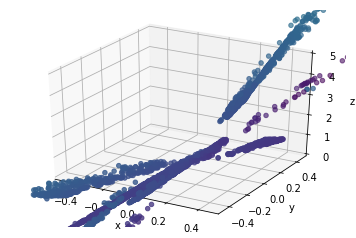

In [22]:
#         fig = plt.figure()
ax = plt.axes(projection='3d')


# Data for three-dimensional scattered points
ax.scatter3D(X_3D[:,0], X_3D[:,1], X_3D[:,2], c=X_3D[:,2], cmap='viridis');  #viridis
# plt.scatter(all_X_new[:,0], all_X_new[:,2], c=all_X_new[:,2], cmap='viridis');  #viridis
#         ax = plt.gca()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim([-0.5,0.5])
ax.set_ylim([-0.5,0.5])
ax.set_zlim([0,5])

(0, 2)

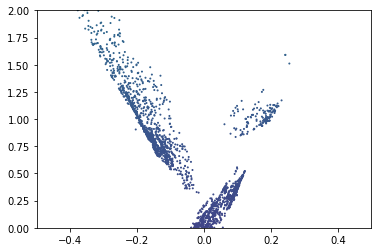

In [26]:
plt.scatter(X_3D[:,0], X_3D[:,2], c=X_3D[:,2], cmap='viridis',s = 1);  #viridis
# plt.set_xlabel('x')
# ax.set_ylabel('y')
# plt.set_ylabel('z');
axes = plt.gca()
axes.set_xlim([-0.5,0.5])
axes.set_ylim([0,2])